In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from quantum_tunneling.workflows import run_bound_states
from quantum_tunneling.wkb import barrier_check
from quantum_tunneling.fields import apply_field

plt.rcParams.update({"figure.figsize": (8, 4.5)})

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

# Part B (v2) — WKB 状态判据可视化
本 notebook 服务于 `report_v2.md` 的 Part B：
- 给定 $V(x)$、能量 $E_n$，用 `barrier_check` 自动分类势垒状态：`can_tunnel` / `no_closed_barrier` / `over_the_barrier`。
- 对每种状态画出：倾斜势能 $V(x)-Fx$、能量线、势垒顶、转折点（若存在）、以及禁阻区（$V>E$）阴影。

说明：本项目的 WKB 透射率使用指数形式 $T_{\mathrm{WKB}}=\exp(-2S/\hbar)$（忽略前因子）。

In [21]:
# 1) 选择势与定态：这里用 cusp 作为示例（与你的报告一致）
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 5.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 5.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": 5.0}},
    "soft_well": {"kind": "soft_barrier", "params": {"V0": -5.0}},  # 平滑长尾“阱”，用于对比曲率影响
    "square_well": {"kind": "square", "params": {"offset": 0.0, "width": 4.0, "depth": 8.0}},  # 不光滑边界对比
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}

pot_key = "cusp"
state_index = 0

cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": 50.0, "N": 1200},
    "solver": {"k": 6, "hbar": 1.0, "m": 1.0},
}

cfg

{'potential': {'kind': 'cusp', 'params': {'V0': 5.0, 'alpha': 0.5}},
 'grid': {'L': 50.0, 'N': 1200},
 'solver': {'k': 6, 'hbar': 1.0, 'm': 1.0}}

In [13]:
res = run_bound_states(cfg)
x = res["x"]
Vx = res["Vx"]
E = res["E"]

print("Selected potential:", pot_key)
print("state_index:", state_index, "E_n:", float(E[state_index]))

Selected potential: cusp
state_index: 0 E_n: 3.3555328340301864


In [14]:
def plot_barrier_case(x, Vtilt, E_n, rec, *, title="", savepath=None):
    plt.figure()
    plt.plot(x, Vtilt, lw=2, label=r"$V(x)-Fx$")
    plt.axhline(E_n, color="k", ls="--", lw=1.5, label=r"$E_n$")

    # 禁阻区阴影：V > E
    mask = Vtilt > E_n
    if np.any(mask):
        plt.fill_between(x, E_n, Vtilt, where=mask, color="tab:orange", alpha=0.25, label=r"$V>E$ (forbidden)")

    # 势垒顶
    if "barrier_top" in rec and rec["barrier_top"] is not None:
        xtop, vtop, _ = rec["barrier_top"]
        plt.scatter([xtop], [vtop], color="tab:red", zorder=5, label=r"barrier top")

    # 转折点（若存在）
    tps = rec.get("turning_points")
    if tps is not None:
        x1, x2 = tps
        plt.axvline(x1, color="tab:green", ls=":", lw=2, label=r"turning points")
        plt.axvline(x2, color="tab:green", ls=":", lw=2)

    status = rec.get("status", "")
    extra = []
    if "S" in rec:
        extra.append(f"S={rec['S']:.4g}")
    if "T_wkb" in rec:
        extra.append(f"T_wkb={rec['T_wkb']:.3e}")
    subtitle = (status + (" | " + ", ".join(extra) if extra else "")).strip()

    plt.title(title + ("\n" + subtitle if subtitle else ""))
    plt.xlim(-5,50)
    plt.ylim(min(Vtilt)-1, 40)
    plt.xlabel("x")
    plt.ylabel("V")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=200)
    plt.show()

## 2) 三种势垒状态示例
下面我们通过调整外场 $F$ 与转折点搜索下限 `x_min`，分别构造并可视化：
- `can_tunnel`：存在闭合势垒且 $E_n < V_{top}$，可算 $S$ 与 $T_{WKB}$
- `no_closed_barrier`：在给定搜索区间内找不到两个转折点（常见原因：网格不够大或 `x_min` 设置不当）
- `over_the_barrier`：$E_n > V_{top}$，已越过势垒顶，WKB 隧穿公式不适用


=== can_tunnel ===
F= 0.65 x_min= 0.0
{'status': 'can_tunnel(3.3555 < 9.6154, Tunneling Points: 0.5522 to 48.2951)', 'barrier': True, 'barrier_top': (14.77935054121565, 9.6153825979244, 777), 'turning_points': (0.5522388790703773, 48.295055119470575), 'S': 132.6399513737817, 'T_wkb': 6.171661198871173e-116}


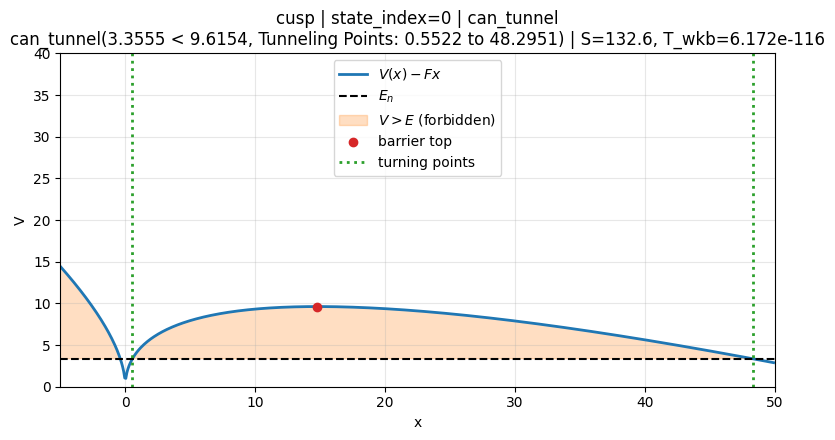

saved: figures\part_b_status_cusp_n0_can_tunnel.png

=== no_closed_barrier ===
F= 0.0 x_min= 0.0
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (49.91673605328893, 35.32588854271359, 1199)}


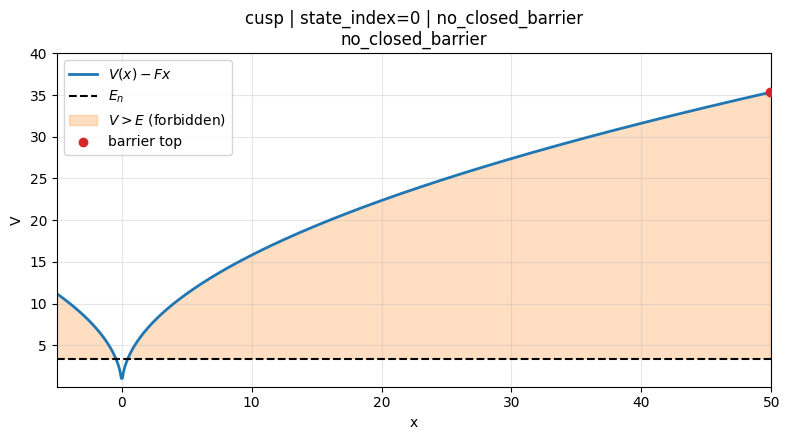

saved: figures\part_b_status_cusp_n0_no_closed_barrier.png

=== over_the_barrier ===
F= 1.875 x_min= 0.0
{'status': 'over_the_barrier', 'barrier': False, 'barrier_top': (1.7901748542880895, 3.3332929509385547, 621)}


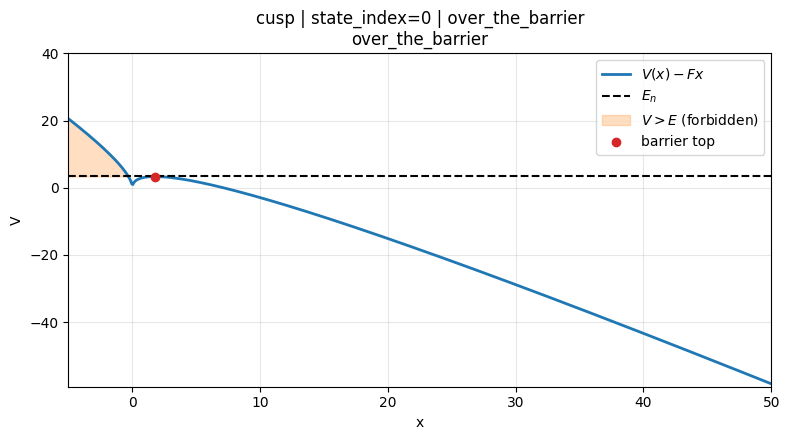

saved: figures\part_b_status_cusp_n0_over_the_barrier.png


In [15]:
E_n = float(E[state_index])

def find_record(*, target: str):
    """在一组(F, x_min)候选中搜索指定 target 状态。"""
    F_candidates = np.linspace(0.0, 2.5, 101)  # 覆盖较宽范围，便于找到 over_the_barrier
    x_min_candidates = [0.0, 2.0, 5.0, 10.0, 15.0, 20.0]  # 用于触发 no_closed_barrier 的示例
    for x_min in x_min_candidates:
        for F in F_candidates:
            Vtilt = apply_field(Vx, x, float(F))
            rec = barrier_check(x, Vtilt, E_n, x_min=float(x_min))
            status = rec.get("status", "")
            if target == "can_tunnel" and rec.get("barrier", False):
                return {"F": float(F), "x_min": float(x_min), "rec": rec, "Vtilt": Vtilt}
            if target == "no_closed_barrier" and status == "no_closed_barrier":
                return {"F": float(F), "x_min": float(x_min), "rec": rec, "Vtilt": Vtilt}
            if target == "over_the_barrier" and status == "over_the_barrier":
                return {"F": float(F), "x_min": float(x_min), "rec": rec, "Vtilt": Vtilt}
    raise RuntimeError(f"Failed to find a case for target={target}")

cases = {name: find_record(target=name) for name in ["can_tunnel", "no_closed_barrier", "over_the_barrier"]}
for name, case in cases.items():
    print("\n===", name, "===")
    print("F=", case["F"], "x_min=", case["x_min"])
    print(case["rec"])
    out = FIG_DIR / f"part_b_status_{pot_key}_n{state_index}_{name}.png"
    plot_barrier_case(
        x,
        case["Vtilt"],
        E_n,
        case["rec"],
        title=f"{pot_key} | state_index={state_index} | {name}",
        savepath=out,
    )
    print("saved:", out)

## 3) 连续扫场：从 `can_tunnel` 走向 `over_the_barrier`
为了配合 Part C 的扫场叙述，这里额外给出一个 $\ln T_{\mathrm{WKB}}$ 随 $F$ 的曲线（当状态变为 `over_the_barrier` 时，WKB 不再适用，对应点会显示为 `nan`）。

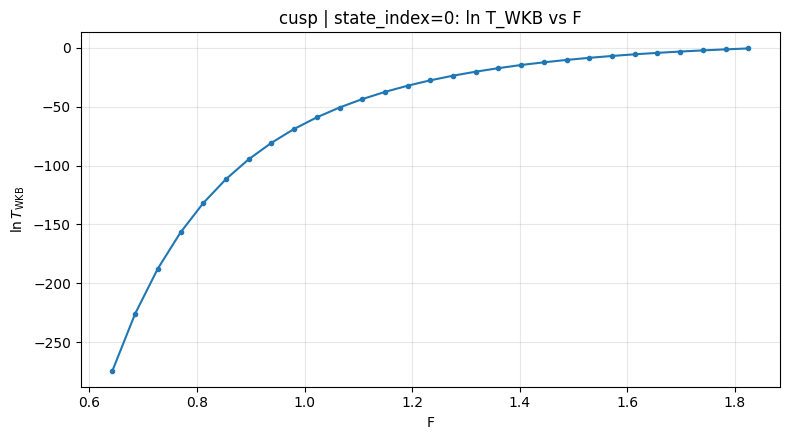

F=0.010 -> no_closed_barrier
F=0.052 -> no_closed_barrier
F=0.094 -> no_closed_barrier
F=0.137 -> no_closed_barrier
F=0.179 -> no_closed_barrier
F=0.221 -> no_closed_barrier
F=0.263 -> no_closed_barrier
F=0.305 -> no_closed_barrier
F=0.348 -> no_closed_barrier
F=0.390 -> no_closed_barrier
F=0.432 -> no_closed_barrier
F=0.474 -> no_closed_barrier
F=0.516 -> no_closed_barrier
F=0.559 -> no_closed_barrier
F=0.601 -> no_closed_barrier
F=1.867 -> over_the_barrier
F=1.909 -> over_the_barrier
F=1.951 -> over_the_barrier
F=1.994 -> over_the_barrier
F=2.036 -> over_the_barrier
F=2.078 -> over_the_barrier
F=2.120 -> over_the_barrier
F=2.162 -> over_the_barrier
F=2.205 -> over_the_barrier
F=2.247 -> over_the_barrier
F=2.289 -> over_the_barrier
F=2.331 -> over_the_barrier
F=2.373 -> over_the_barrier
F=2.416 -> over_the_barrier
F=2.458 -> over_the_barrier
F=2.500 -> over_the_barrier


In [16]:
F_grid = np.linspace(0.01, 2.5, 60)
lnT = []
status_list = []
for F in F_grid:
    Vtilt = apply_field(Vx, x, float(F))
    rec = barrier_check(x, Vtilt, E_n, x_min=0.0)
    status_list.append(rec.get("status"))
    if rec.get("barrier", False):
        lnT.append(np.log(rec["T_wkb"]))
    else:
        lnT.append(np.nan)

plt.figure()
plt.plot(F_grid, lnT, marker="o", ms=3)
plt.xlabel("F")
plt.ylabel(r"$\ln T_{\mathrm{WKB}}$")
plt.title(f"{pot_key} | state_index={state_index}: ln T_WKB vs F")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 打印状态切换点（便于写进报告）
for F, st in zip(F_grid, status_list):
    if st in ("no_closed_barrier", "over_the_barrier"):
        print(f"F={F:.3f} -> {st}")

## 4) 曲率/非光滑度如何影响 WKB accuracy（回答题目点）
WKB 的核心假设是势能在一个局部德布罗意波长尺度上“变化缓慢”。当势垒顶部/转折点附近曲率很大，或势本身不光滑（如 cusp / rough）时，WKB 的匹配与指数因子更容易出现系统偏差。
本节给出两类可计算指标：
- **势垒曲率**：$V''(x_{top})$（用有限差分近似）。
- **WKB 有效性参数（proxy for accuracy）**：在禁阻区定义 $\kappa(x)=\sqrt{2m(V-E)}/\hbar$，用 $\eta(x)=|\kappa'(x)|/\kappa(x)^2$ 衡量“变化是否缓慢”；取禁阻区最大值 $\eta_{max}$。值越小，WKB 越可信。
另外，为了强调“非光滑”，我们也统计转折点附近的 $|V''|$ 峰值作为 roughness 指标。

In [17]:
def second_derivative(y, dx):
    dy = np.gradient(y, dx)
    d2y = np.gradient(dy, dx)
    return d2y


def wkb_validity_metrics(x, Vtilt, E_n, *, hbar=1.0, m=1.0, top_idx=None, turning_points=None):
    """返回一组用于讨论 WKB accuracy 的 proxy 指标。

    指标：
    - curv_top: 势垒顶处的 V''(x_top)（有限差分）
    - kappa_eta_max: 禁阻区 WKB 有效性参数 eta=|kappa'|/kappa^2 的最大值（越小越好）
    - rough_turn: 转折点附近 |V''| 峰值（衡量非光滑/粗糙）
    """
    dx = float(x[1] - x[0])
    d2V = second_derivative(Vtilt, dx)

    # forbidden region: V > E
    mask_forbidden = Vtilt > E_n
    kappa = np.zeros_like(x, dtype=float)
    kappa[mask_forbidden] = np.sqrt(np.maximum(0.0, 2.0 * m * (Vtilt[mask_forbidden] - E_n))) / hbar
    dkappa = np.gradient(kappa, dx)

    valid = kappa > 0
    eta = np.full_like(x, np.nan, dtype=float)
    eta[valid] = np.abs(dkappa[valid]) / np.maximum(1e-12, kappa[valid] ** 2)
    kappa_eta_max = float(np.nanmax(eta)) if np.any(valid) else np.nan

    curv_top = float(d2V[top_idx]) if top_idx is not None else np.nan

    rough_turn = np.nan
    if turning_points is not None:
        x1, x2 = turning_points
        i1 = int(np.argmin(np.abs(x - x1)))
        i2 = int(np.argmin(np.abs(x - x2)))
        w = 10  # 取10个网格点窗口
        s1 = slice(max(0, i1 - w), min(len(x), i1 + w + 1))
        s2 = slice(max(0, i2 - w), min(len(x), i2 + w + 1))
        rough_turn = float(np.nanmax(np.abs(np.r_[d2V[s1], d2V[s2]])))

    return {
        "curv_top": curv_top,
        "kappa_eta_max": kappa_eta_max,
        "rough_turn": rough_turn,
        "dx": dx,
    }

In [18]:
def solve_and_find_can_tunnel(pot_key, state_index, *, L=50.0, N=1200, k=6, x_min=0.0):
    cfg_local = {
        "potential": potentials[pot_key],
        "grid": {"L": float(L), "N": int(N)},
        "solver": {"k": int(k), "hbar": 1.0, "m": 1.0},
    }
    res_local = run_bound_states(cfg_local)
    x_local = res_local["x"]
    Vx_local = res_local["Vx"]
    E_local = res_local["E"]
    E_n_local = float(E_local[state_index])

    # 搜索一个 can_tunnel 的 F（用于对比）
    F_candidates = np.linspace(0.0, 2.5, 251)
    for F in F_candidates:
        Vtilt = apply_field(Vx_local, x_local, float(F))
        rec = barrier_check(x_local, Vtilt, E_n_local, x_min=float(x_min))
        if rec.get("barrier", False):
            return {
                "cfg": cfg_local,
                "res": res_local,
                "x": x_local,
                "Vx": Vx_local,
                "E_n": E_n_local,
                "F": float(F),
                "Vtilt": Vtilt,
                "rec": rec,
            }
    raise RuntimeError(f"No can_tunnel found for pot_key={pot_key} in F grid")

In [22]:
# 对比：不同势的“曲率/非光滑”指标 vs WKB 有效性参数
compare_keys = ["cusp", "exp_well", "soft_well", "square_well"]
rows = []
cases_can = {}
for key in compare_keys:
    case = solve_and_find_can_tunnel(key, state_index=state_index, x_min=0.0)
    cases_can[key] = case
    rec = case["rec"]
    x_local = case["x"]
    Vtilt = case["Vtilt"]
    E_n_local = case["E_n"]
    xtop, vtop, top_idx = rec["barrier_top"]
    turning = rec.get("turning_points")
    mets = wkb_validity_metrics(x_local, Vtilt, E_n_local, top_idx=top_idx, turning_points=turning)

    # 归一化曲率（无量纲）：|V''(x_top)| * (x2-x1)^2 / (V_top - E)
    curv_norm = np.nan
    if turning is not None:
        x1, x2 = turning
        denom = max(1e-12, float(vtop - E_n_local))
        curv_norm = abs(float(mets["curv_top"])) * (float(x2 - x1) ** 2) / denom

    rows.append({
        "potential": key,
        "F_can_tunnel": case["F"],
        "E_n": E_n_local,
        "V_top": float(vtop),
        "S": float(rec.get("S", np.nan)),
        "lnT_wkb": float(np.log(rec["T_wkb"])) if rec.get("barrier") else np.nan,
        "curv_top": float(mets["curv_top"]),
        "curv_norm": float(curv_norm),
        "eta_max": float(mets["kappa_eta_max"]),
        "rough_turn": float(mets["rough_turn"]),
        "turning_points": turning,
    })

print("\n--- metrics table (proxy for WKB accuracy) ---")
for r in rows:
    print(
        f"{r['potential']:<12} F={r['F_can_tunnel']:.3f} "
        f"curv_norm={r['curv_norm']:.3g} eta_max={r['eta_max']:.3g} rough_turn={r['rough_turn']:.3g} lnT={r['lnT_wkb']:.1f}"
    )


--- metrics table (proxy for WKB accuracy) ---
cusp         F=0.650 curv_norm=8.01 eta_max=64.4 rough_turn=72.4 lnT=-265.3
exp_well     F=0.070 curv_norm=47.2 eta_max=103 rough_turn=40.3 lnT=-135.8
soft_well    F=0.080 curv_norm=31.3 eta_max=172 rough_turn=9.63 lnT=-161.5
square_well  F=0.160 curv_norm=8.4e+04 eta_max=158 rough_turn=288 lnT=-238.7


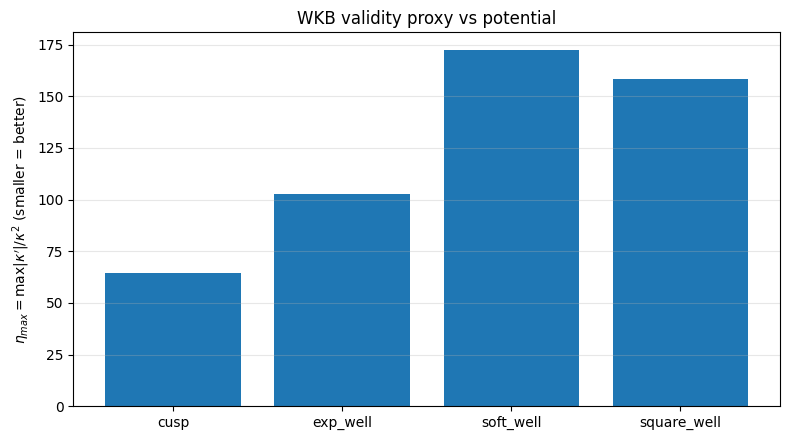

saved: figures\part_b_wkb_validity_eta_n0.png


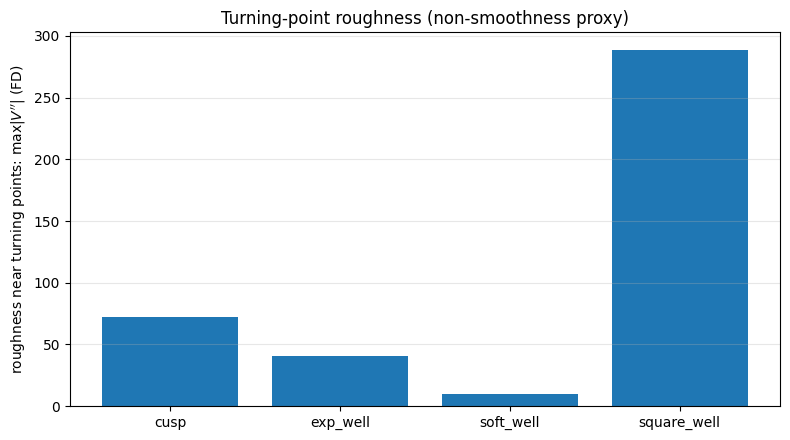

saved: figures\part_b_turning_roughness_n0.png


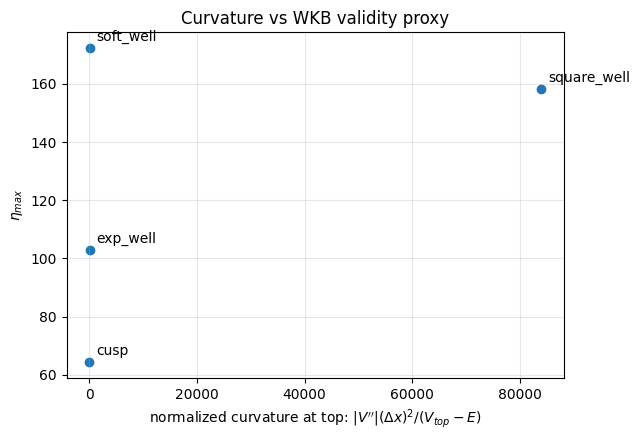

saved: figures\part_b_curvature_vs_eta_n0.png


In [23]:
# 可视化：曲率/roughness 与 WKB 有效性参数的关系
pot_names = [r["potential"] for r in rows]
eta_vals = [r["eta_max"] for r in rows]
curv_vals = [r["curv_norm"] for r in rows]
rough_vals = [r["rough_turn"] for r in rows]

plt.figure(figsize=(8, 4.5))
plt.bar(pot_names, eta_vals)
plt.ylabel(r"$\eta_{max}=\max |\kappa'|/\kappa^2$ (smaller = better)")
plt.title("WKB validity proxy vs potential")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
out1 = FIG_DIR / f"part_b_wkb_validity_eta_n{state_index}.png"
plt.savefig(out1, dpi=200)
plt.show()
print("saved:", out1)

plt.figure(figsize=(8, 4.5))
plt.bar(pot_names, rough_vals)
plt.ylabel(r"roughness near turning points: $\max |V''|$ (FD)")
plt.title("Turning-point roughness (non-smoothness proxy)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
out2 = FIG_DIR / f"part_b_turning_roughness_n{state_index}.png"
plt.savefig(out2, dpi=200)
plt.show()
print("saved:", out2)

plt.figure(figsize=(6.5, 4.5))
plt.scatter(curv_vals, eta_vals)
for r in rows:
    plt.annotate(r["potential"], (r["curv_norm"], r["eta_max"]), textcoords="offset points", xytext=(5, 5))
plt.xlabel(r"normalized curvature at top: $|V''| (\Delta x)^2/(V_{top}-E)$")
plt.ylabel(r"$\eta_{max}$")
plt.title("Curvature vs WKB validity proxy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
out3 = FIG_DIR / f"part_b_curvature_vs_eta_n{state_index}.png"
plt.savefig(out3, dpi=200)
plt.show()
print("saved:", out3)